<a href="https://colab.research.google.com/github/deepsyyt/ML-problem/blob/master/ML_problem_filight_delay_prediction_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.1 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Pre-requisites
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# file copy
import shutil

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# Classifiers from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pointbiserialr



## **Selecting only recommended airport codes , columns and year from weather data**

In [ ]:
# List of airport codes
airport_codes = ["ATL","CLT","DEN","DFW","EWR","IAH","JFK","LAS","LAX","MCO",
"MIA","ORD","PHX","SEA","SFO"]  # Add all your airport codes

base_path = '/content/drive/MyDrive/ML project/weather'
destination_path = '/content/drive/MyDrive/ML project/selected_weather'

# selected_years
selected_years = ["2016", "2017"]

for airport_code in airport_codes:
    airport_folder = os.path.join(base_path, airport_code)
    for year in selected_years:
        for month in range(1, 13):
            json_file_name = f"{year}-{month}.json"
            json_file_path = os.path.join(airport_folder, json_file_name)
            # Checking if the file exists before copying
            if os.path.exists(json_file_path):
                # Destination folder for the selected years
                destination_folder = os.path.join(destination_path, airport_code, year)
                # Create the destination folder if it doesn't exist
                os.makedirs(destination_folder, exist_ok=True)
                # Copying the file to the destination
                shutil.copy(json_file_path, destination_folder)
print("copy completed")

In [ ]:
selected_columns_weather = ["windspeedKmph","winddirDegree","weatherCode","precipMM",
"visibility","pressure","cloudcover","DewPointF","WindGustKmph","tempF","WindChillF",
"humidity","date","time","airport"]

# DataFrame to store all weather data
final_weather_df = []

base_path_selected_years = '/content/drive/MyDrive/ML project/selected_weather'
# Iterating through each airport, year, and month
for airport_code in os.listdir(base_path_selected_years):
    airport_folder = os.path.join(base_path_selected_years, airport_code)

    for year in os.listdir(airport_folder):
        year_folder = os.path.join(airport_folder, year)

        for month in range(1, 13):
            json_file_name = f"{year}-{month}.json"
            json_file_path = os.path.join(year_folder, json_file_name)

            if os.path.exists(json_file_path):
                # Reading JSON file
                with open(json_file_path, 'r') as f:
                    data = json.load(f)

            # Extracting data from "weather" key
            weather_data = data.get('data', {}).get('weather', [])

            # Extracting data from "request" key
            request_data = data.get('data', {}).get('request', [{}])[0]

            # Normalizing the JSON data using pandas.json_normalize
            df_weather = pd.json_normalize(weather_data, 'hourly', ['date'])

            # Adding the "query" information to the DataFrame
            df_weather['airport'] = request_data.get('query', None)
            selected_weather_data = df_weather[selected_columns_weather]
            # Appending the DataFrame to the list
            final_weather_df.append(selected_weather_data)

# Concatenating all DataFrames in the list
final_weather_df = pd.concat(final_weather_df, ignore_index=True)
final_weather_df['airport'] = final_weather_df['airport'].str.extract(r'([A-Z]{3})')
print(final_weather_df.shape)
# copying  the resulting DataFrame
final_weather_df.to_csv('/content/drive/MyDrive/ML project/final_weather_df.csv', index=False)

(263160, 15)


In [8]:
# the CSV file import
final_weather_df = pd.read_csv('/content/drive/MyDrive/ML project/final_weather_df.csv')

In [ ]:
final_weather_df.head()

,windspeedKmph,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,humidity,date,time,airport
0,11,318,176,0.1,10,1023,100,47,17,49,46,91,2016-01-01,0,ATL
1,13,317,176,0.0,10,1023,100,44,22,46,42,92,2016-01-01,100,ATL
2,14,315,122,0.0,10,1023,100,41,26,43,38,92,2016-01-01,200,ATL
3,16,314,122,0.0,10,1023,100,38,30,40,33,93,2016-01-01,300,ATL
4,17,314,122,0.0,10,1023,100,38,30,40,33,93,2016-01-01,400,ATL


## **Selecting recommended columns and rows from the Json file of each recomended airport_code**

Unzipping flight data

In [ ]:
import zipfile
import os

# creating the path to your zip file flight data
zip_file_flight_path = '/content/drive/MyDrive/ML project/Flight Data'

# the destination folder to unzip the data
extracted_folder_path_flight = '/content/drive/MyDrive/ML project/unzipped_flight_data'

# Creating the destination folder
os.makedirs(extracted_folder_path_flight, exist_ok=True)

 # Listing all zip files in the folder
zip_files = [file for file in os.listdir(zip_file_flight_path)]
# Unzippiing each file
for zip_file in zip_files:
    zip_file_path = os.path.join(zip_file_flight_path, zip_file)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
         zip_ref.extractall(extracted_folder_path_flight)

# Checking the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path_flight)
print(extracted_files)

['2017', '2016']


Selecting only recommended columns from the flight data for recommended airportt codes

In [ ]:
select_flight_data_columns = ["Origin","FlightDate","Quarter","Year","Month",
"DayofMonth","DepTime","DepDel15","CRSDepTime","DepDelayMinutes",'Dest',
"OriginAirportID","DestAirportID","ArrTime","CRSArrTime","ArrDel15",
"ArrDelayMinutes"]

Destination_id = [10397,11057,11292,11298,11618,12266,12478,12889,12892,
13204,13303,13930,14107,14747,14771]

extracted_folder_path_flight = '/content/drive/MyDrive/ML project/unzipped_flight_data'
# Iterating through the years
all_dataframes=[]
for year in os.listdir(extracted_folder_path_flight):
    path_year_folder = os.path.join(extracted_folder_path_flight, year)
    #Recursively iterating through all subdirectories and files
    for root, dirs, files in os.walk(path_year_folder):
        for file_name in files:
        # Checking if the file is a CSV file
            if file_name.endswith('.csv'):
            # Constructing the full path to the CSV file
               csv_path = os.path.join(root, file_name)
               # Reading the CSV file into a DataFrame
               df_flight = pd.read_csv(csv_path, usecols=select_flight_data_columns)
               #print(df_flight.shape)
               all_dataframes.append(df_flight)

flight_final_df = pd.concat(all_dataframes, ignore_index=True)
condition_origin = flight_final_df['Origin'].isin(airport_codes)
condition_dest = flight_final_df['Dest'].isin(airport_codes)
flight_final_df = flight_final_df[condition_origin]
flight_final_df = flight_final_df[condition_dest]
condition_destination = flight_final_df['DestAirportID'].isin(Destination_id)
flight_final_df = flight_final_df[condition_destination]
print(flight_final_df.shape)
flight_final_df.head()

<ipython-input-8-429eae8a5464>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  flight_final_df = flight_final_df[condition_dest]


(1877296, 17)


,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15
0,2017,1,1,17,2017-01-17,11057,CLT,14107,PHX,1619,1616.0,0.0,0.0,1856,1842.0,0.0,0.0
1,2017,1,1,18,2017-01-18,11057,CLT,14107,PHX,1619,1614.0,0.0,0.0,1856,1821.0,0.0,0.0
2,2017,1,1,19,2017-01-19,11057,CLT,14107,PHX,1619,1611.0,0.0,0.0,1856,1826.0,0.0,0.0
3,2017,1,1,20,2017-01-20,11057,CLT,14107,PHX,1619,1656.0,37.0,1.0,1856,1929.0,33.0,1.0
4,2017,1,1,21,2017-01-21,11057,CLT,14107,PHX,1619,1632.0,13.0,0.0,1856,1858.0,2.0,0.0


In [ ]:
flight_final_df.isna().sum()

Year                   0
Quarter                0
Month                  0
DayofMonth             0
FlightDate             0
OriginAirportID        0
Origin                 0
DestAirportID          0
Dest                   0
CRSDepTime             0
DepTime            20980
DepDelayMinutes    20987
DepDel15           20987
CRSArrTime             0
ArrTime            22080
ArrDelayMinutes    25860
ArrDel15           25860
dtype: int64

In [ ]:
# dropping null values
flight_df = flight_final_df.dropna()

Rounding the CRSDepTime to join the flight and weather data

In [ ]:
# Creating a list to store the rounded CRSDepTime of flight data
new_time = []
# Iterating through CRSDepTime
for time in flight_df["CRSDepTime"]:
    time = int(time)
    # Obtaining the minutes
    m = time % 100
    # If it is less than 30 mins, just subtract to round down
    if m < 30:
        time = time - m
    # If it is greater than or equal to 30 mins, round up
    elif(m >= 30) :
        time = time + (100 - m)
    # If it is 2400, make it 0
    if(time == 2400):
        time = 0
    new_time.append(time)
flight_df["approximate_CRSDepTime"] = new_time
flight_df[["approximate_CRSDepTime", "CRSDepTime"]]

<ipython-input-17-1461cc926218>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_df["approximate_CRSDepTime"] = new_time


,approximate_CRSDepTime,CRSDepTime
0,1600,1619
1,1600,1619
2,1600,1619
3,1600,1619
4,1600,1619
...,...,...
11292273,1500,1445
11292274,600,600
11292275,1600,1609
11292277,1900,1900


Writing the final flight data into the folder

In [ ]:
flight_df.to_csv('/content/drive/MyDrive/ML project/flight_df.csv')

Reading the flight_df csv file from the folder

In [9]:
# the CSV file download
flight_df = pd.read_csv('/content/drive/MyDrive/ML project/flight_df.csv')

# **Merging Fight data with weather data on the departure airport, scheduled departure time and date**

In [10]:
# Mergeing based on Origin",'FlightDate","approximate_CRSDepTime"
merged_df = pd.merge(flight_df, final_weather_df, left_on=["Origin",'FlightDate','approximate_CRSDepTime'], right_on=["airport",'date','time'], how='inner')
# Drop the default index column
merged_df = merged_df.drop(columns=['Unnamed: 0'])

# Print the shape of the merged DataFrame
print(f"{merged_df.shape} merged df rows and columns")

# Display the head of the merged DataFrame
merged_df.head()

(1851436, 33) merged df rows and columns


,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,approximate_CRSDepTime,windspeedKmph,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,humidity,date,time,airport
0,2017,1,1,17,2017-01-17,11057,CLT,14107,PHX,1619,1616.0,0.0,0.0,1856,1842.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
1,2017,1,1,17,2017-01-17,11057,CLT,11618,EWR,1610,1700.0,50.0,1.0,1801,1857.0,56.0,1.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
2,2017,1,1,17,2017-01-17,11057,CLT,13303,MIA,1619,1614.0,0.0,0.0,1832,1847.0,15.0,1.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
3,2017,1,1,17,2017-01-17,11057,CLT,12892,LAX,1615,1618.0,3.0,0.0,1852,1823.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
4,2017,1,1,17,2017-01-17,11057,CLT,10397,ATL,1610,1603.0,0.0,0.0,1724,1714.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT


Writing the final flight data into the folder

In [12]:
merged_df.to_csv('/content/drive/MyDrive/ML project/merged_df.csv')

Reading the flight_df csv file

In [6]:
# the CSV file download
merged_df = pd.read_csv('/content/drive/MyDrive/ML project/merged_df.csv')

Checking the missing values

Axes(0.125,0.11;0.698618x0.77)


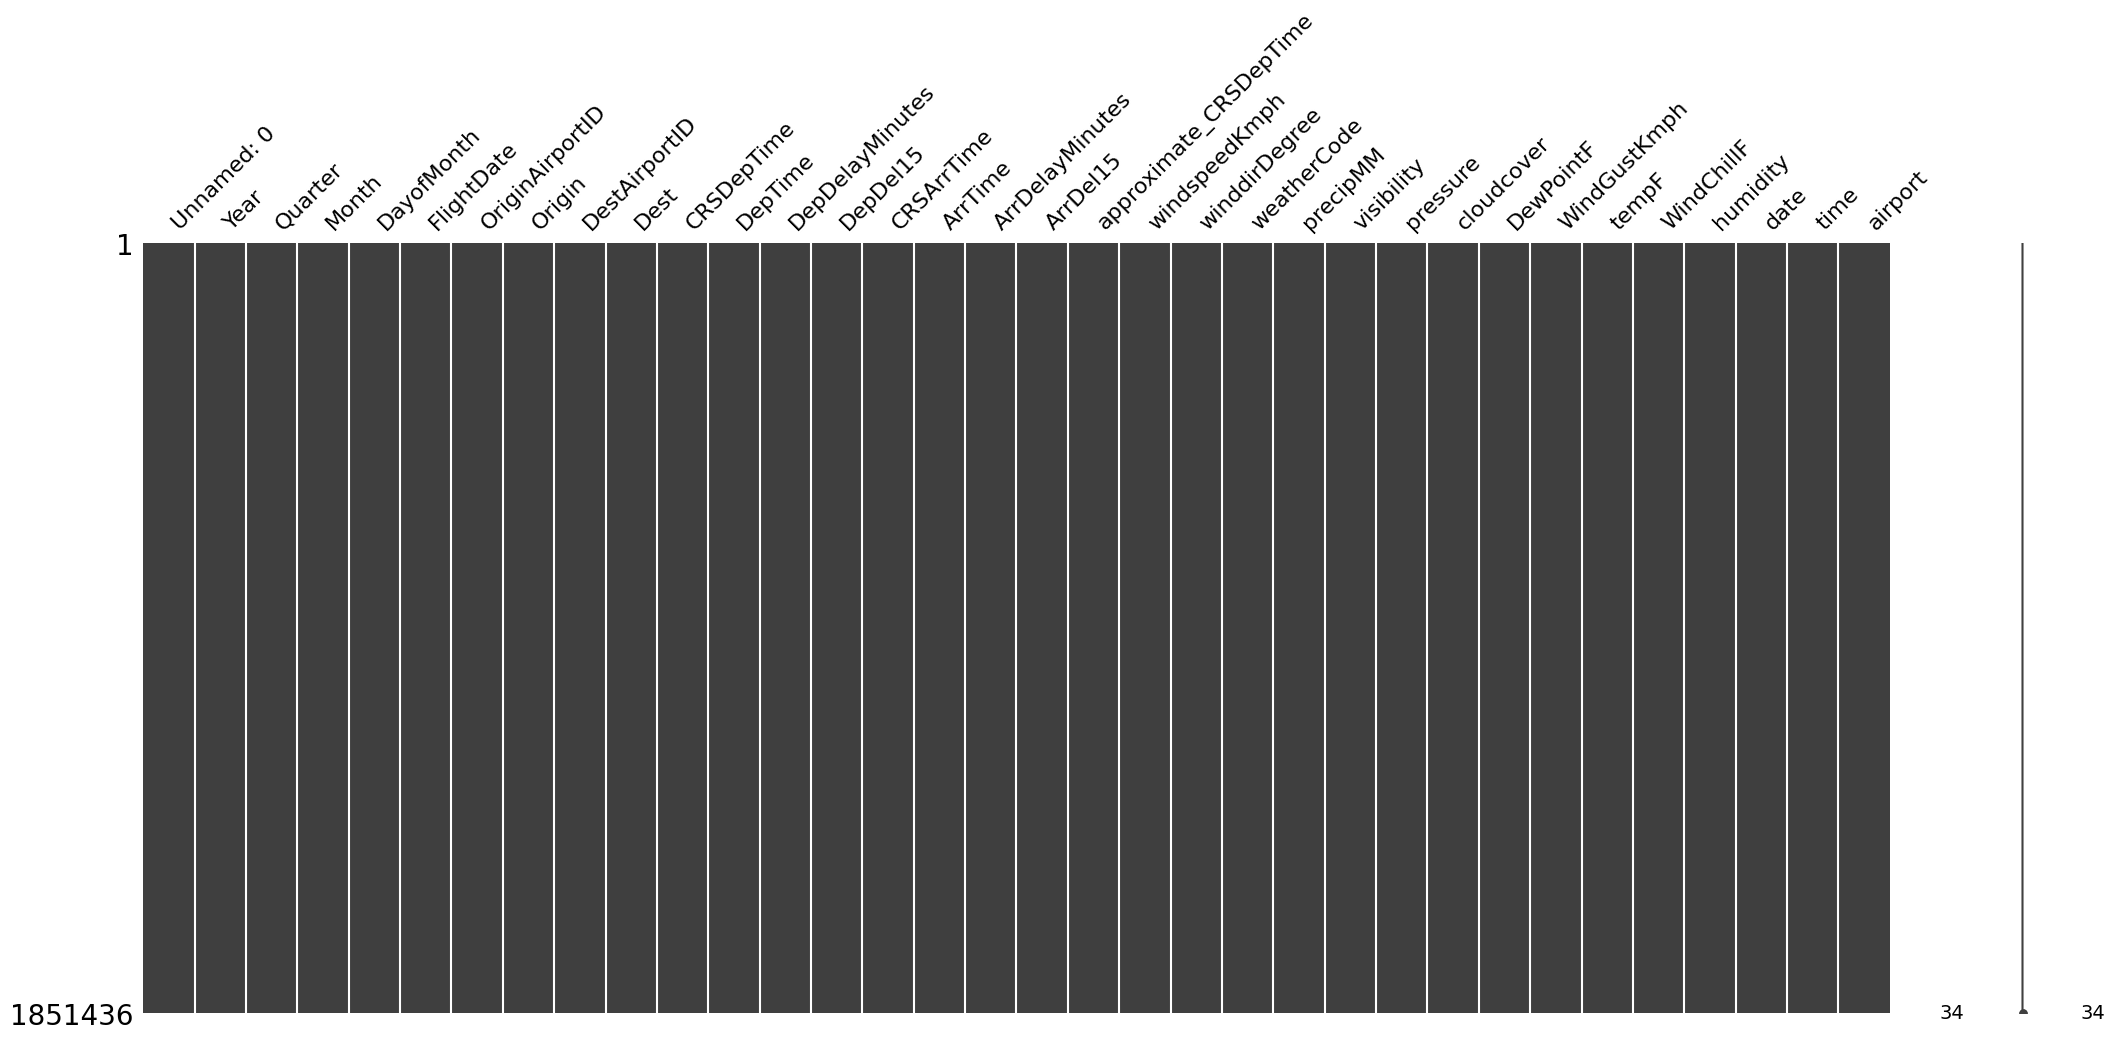

In [14]:
import missingno as msno
merged_df.isna().sum()
print(msno.matrix(merged_df))

In [15]:
merged_df.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,approximate_CRSDepTime,windspeedKmph,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,humidity,date,time,airport
0,0,2017,1,1,17,2017-01-17,11057,CLT,14107,PHX,1619,1616.0,0.0,0.0,1856,1842.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
1,1,2017,1,1,17,2017-01-17,11057,CLT,11618,EWR,1610,1700.0,50.0,1.0,1801,1857.0,56.0,1.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
2,2,2017,1,1,17,2017-01-17,11057,CLT,13303,MIA,1619,1614.0,0.0,0.0,1832,1847.0,15.0,1.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
3,3,2017,1,1,17,2017-01-17,11057,CLT,12892,LAX,1615,1618.0,3.0,0.0,1852,1823.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
4,4,2017,1,1,17,2017-01-17,11057,CLT,10397,ATL,1610,1603.0,0.0,0.0,1724,1714.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT


# **Data Preprocessing**


```
Eliminating Redundancy
FlightDate - The columns Year, Month and DayofMonth give this information in separate columns
OriginAirportID, DestAirportID - same as orgin and dest
"CRSArrTime, ArrTime and ArrDelayMinutes" - leakage information - target ArrDel15
approximate_CRSDepTime -It is a duplicate of time
date -It is a duplicate of FlightDate
airport-It is a duplicate of Origin
```


In [7]:
# Dropping columns with redundant or duplicate data
df = merged_df.drop(['Unnamed: 0','OriginAirportID','DestAirportID',"CRSArrTime",
                 "ArrTime", "ArrDelayMinutes",'airport','approximate_CRSDepTime','date','time'], axis=1)

In [8]:
df['DepDel15'] = df['DepDel15'].astype(int)
df['ArrDel15'] = df['ArrDel15'].astype(int)

## **Checking the Multicolonearity between independent variables**

<ipython-input-10-9471e5e6f99e>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


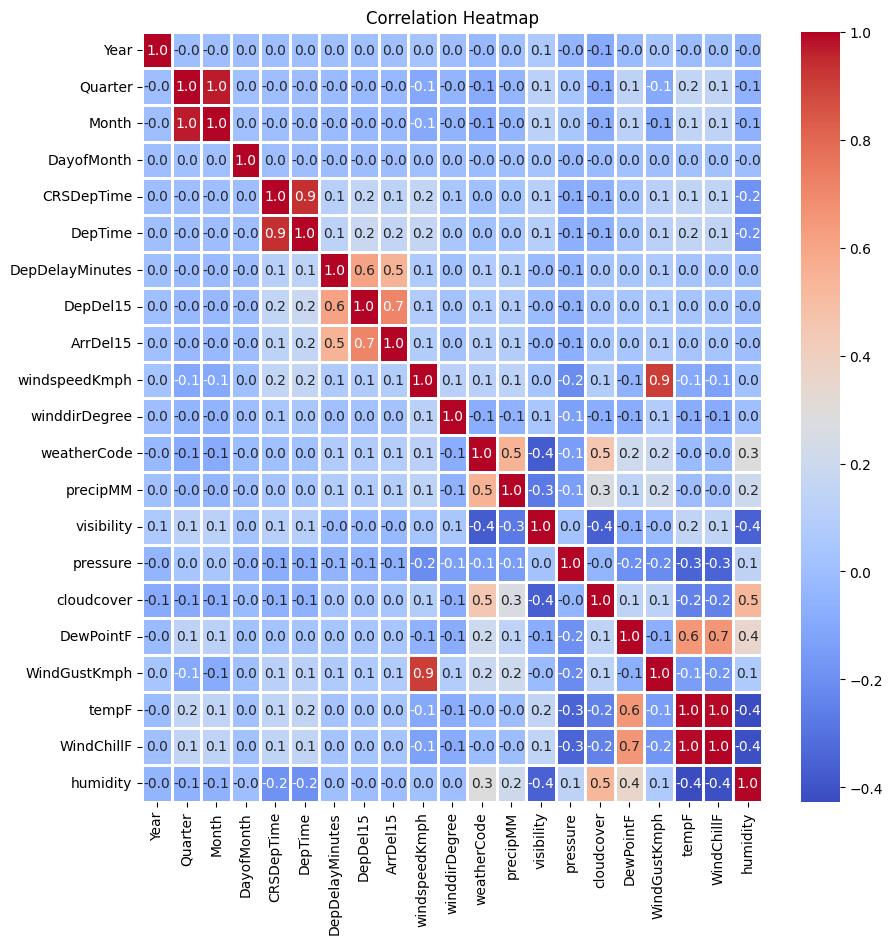

In [ ]:

# Calculating the correlation matrix
correlation_matrix = df.corr()

# Creating a heatmap using Seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.8)
plt.title('Correlation Heatmap')
plt.show()

## **Point Biserial Correlation for Quantitative, Continuous Features with ArrDel15**

In [ ]:
# Encoding categorical data into numeric values
labelEncoder = LabelEncoder()
df["Origin"] = labelEncoder.fit_transform(df["Origin"])
df["Dest"] = labelEncoder.fit_transform(df["Dest"])

categorical = ["Year", "Quarter", "Month", "DayofMonth", "Origin", "Dest",'DepDel15','ArrDel15']
numeric = ['DepDelayMinutes','windspeedKmph','precipMM','visibility', 'pressure', 'cloudcover', 'DewPointF', 'WindGustKmph','tempF', 'WindChillF', 'humidity',
'CRSDepTime','DepTime','winddirDegree','weatherCode']
target = df["ArrDel15"]
# Calculate point-biserial correlation
pbc = list()
for col in numeric:
    ans = pointbiserialr(df[col], target)
    pbc.append([col, ans[0]])

pbc_corr = pd.DataFrame(pbc, columns=["Feature", "CorrCoeff"]).sort_values(by="CorrCoeff", ascending=False).reset_index(drop=True)

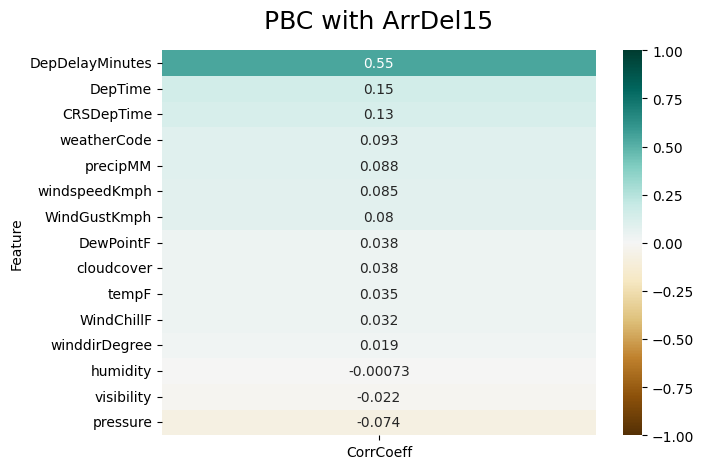

In [ ]:
plt.figure(figsize=(7, 5))
pbc_corr = pbc_corr.set_index("Feature")
heatmap = sns.heatmap(pbc_corr[["CorrCoeff"]].sort_values(by="CorrCoeff", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("PBC with ArrDel15", fontdict={"fontsize":18}, pad=16);
del pbc_corr

## **Spearman Correlation for Categorical Features**

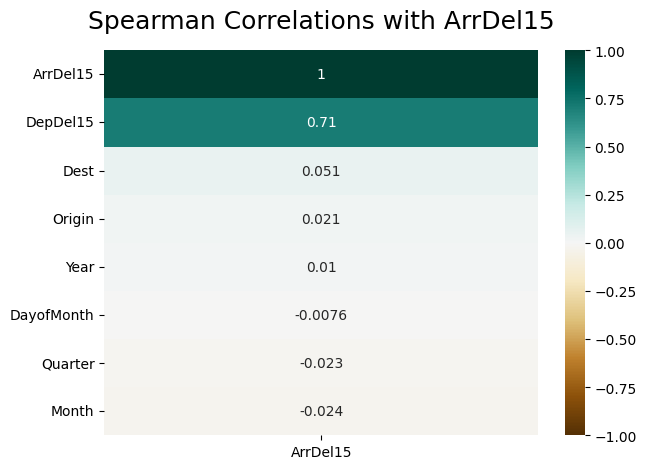

In [ ]:
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(df[categorical].corr(method="spearman")[["ArrDel15"]].sort_values(by="ArrDel15", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations with ArrDel15", fontdict={"fontsize":18}, pad=16)
del heatmap

# **Feature Engineering**

Creating a binary indicator for weekend flights

In [9]:
# Creating a binary indicator for weekend flights
df['FlightDate'] = pd.to_datetime(df['FlightDate'],format='%Y-%m-%d')
df['DayOfWeek'] = pd.to_datetime(df['FlightDate'], format='%Y-%m-%d').dt.dayofweek
df['DayOfWeekName'] = pd.to_datetime(df['FlightDate'], format='%Y-%m-%d').dt.strftime('%A')
df['DayOfWeek'] = df['DayOfWeek'].astype(int)
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

Handling Multicolinearity by converting or deriving new features from correlated features
1. 'CRSDepTime' & 'DepTime'- both are highly coreleated with each other , delay in minutes gives the delay from the CRSDepTime , so removing the DepTime.


In [10]:
#creating new column from the multicolinearity columns to avoid loss of informations
df['AvgWindSpeed'] = (df['windspeedKmph'] + df['WindGustKmph']) / 2
df['AvgTemperature'] = (df['tempF'] + df['WindChillF']) / 2

In [22]:
#dropping redundant features
df_model = df.drop(['tempF','WindChillF','windspeedKmph','WindGustKmph','FlightDate','DayOfWeek'], axis=1)

In [23]:
df_model.head()

,Year,Quarter,Month,DayofMonth,Origin,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,ArrDel15,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,humidity,DayOfWeekName,IsWeekend,AvgWindSpeed,AvgTemperature
0,2017,1,1,17,CLT,PHX,1619,1616.0,0.0,0,0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
1,2017,1,1,17,CLT,EWR,1610,1700.0,50.0,1,1,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
2,2017,1,1,17,CLT,MIA,1619,1614.0,0.0,0,1,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
3,2017,1,1,17,CLT,LAX,1615,1618.0,3.0,0,0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
4,2017,1,1,17,CLT,ATL,1610,1603.0,0.0,0,0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5


In [81]:
# checking the below columns for leakage
grouped_data = df.groupby(['DepDel15', 'ArrDel15']).size().reset_index(name='count')
grouped_data

,DepDel15,ArrDel15,count
0,0,0,1383849
1,0,1,95508
2,1,0,79529
3,1,1,292550


# **Feature selection , checking the feature importance using random forest feature importance**

CatBoost encoding or target encoding is a technique designed specifically for algorithms like CatBoost, which internally handles categorical features. If you are using CatBoost, you don't need to perform explicit encoding, as the library takes care of it.



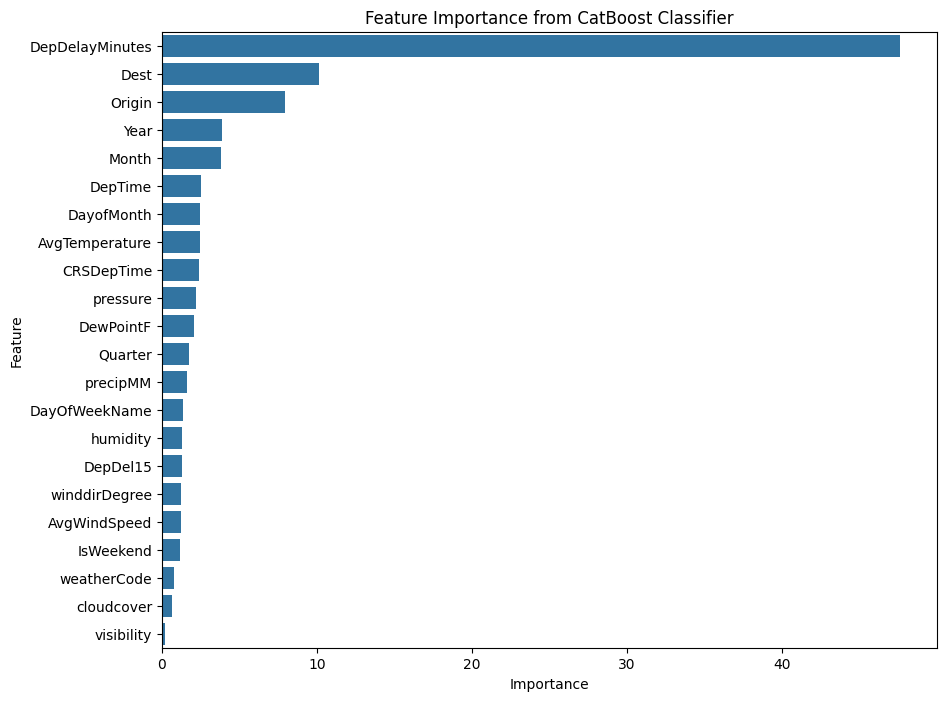

In [30]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df_model.drop(['ArrDel15'], axis=1)
y = df_model['ArrDel15']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, loss_function='Logloss', cat_features=['DepDel15','Origin','Dest','DayOfWeekName','IsWeekend'], verbose=False)

# Training the model
catboost_model.fit(X_train, y_train)

# Getting feature importance
feature_importance = catboost_model.get_feature_importance()

# Mapping feature importance to corresponding column names
feature_importance_mapping = dict(zip(X.columns, feature_importance))

# Sorting the feature importance in descending order
sorted_feature_importance = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)
# Creating a DataFrame for easier plotting
feature_importance_df = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'])

# Ploting the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from CatBoost Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [31]:
df_model.head()

,Year,Quarter,Month,DayofMonth,Origin,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,ArrDel15,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,humidity,DayOfWeekName,IsWeekend,AvgWindSpeed,AvgTemperature
0,2017,1,1,17,CLT,PHX,1619,1616.0,0.0,0,0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
1,2017,1,1,17,CLT,EWR,1610,1700.0,50.0,1,1,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
2,2017,1,1,17,CLT,MIA,1619,1614.0,0.0,0,1,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
3,2017,1,1,17,CLT,LAX,1615,1618.0,3.0,0,0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
4,2017,1,1,17,CLT,ATL,1610,1603.0,0.0,0,0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5


In [32]:
df_model.to_csv('/content/drive/MyDrive/ML project/df_model.csv')

In [34]:
df_model = pd.read_csv('/content/drive/MyDrive/ML project/df_model.csv',index_col=0).reset_index(drop=True)

# **Encoding categorical features**

categorical variable has no ordinal relationship so opting for one hot encoding

In [35]:
#one-hot encoding in pandas
data = pd.get_dummies(df_model, columns=['Origin', 'Dest','DayOfWeekName'])

#**SMOTE To handle imbalance dataset**

In [5]:
data['ArrDel15'].value_counts()

0    1463378
1     388058
Name: ArrDel15, dtype: int64

In [36]:
# Imbalanced dataset helpers
from imblearn.over_sampling import SMOTE

In [6]:
X = data.drop(['ArrDel15'], axis=1)
y = data['ArrDel15']

# X and y are feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create=ing SMOTE instance
smote = SMOTE(k_neighbors=5, n_jobs=-1, random_state=42)

# Fit SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


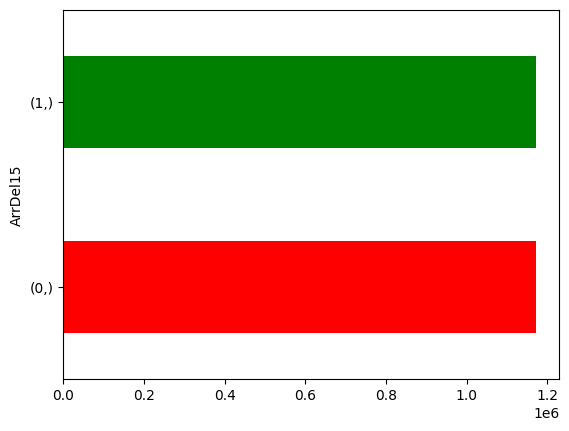

In [7]:
ax = pd.DataFrame(y_train_resampled).value_counts().sort_values().plot(kind="barh", color=["r", "g"])

In [9]:
# #X_train_resampled, y_train_resampled

# # Create a StandardScaler for numerical columns
# scaler = StandardScaler()

# numerical_columns= ['winddirDegree','weatherCode','precipMM','visibility','pressure','cloudcover','DewPointF','humidity','AvgWindSpeed','AvgTemperature']

# # Fit and transform on training data
# X_train_resampled[numerical_columns] = scaler.fit_transform(X_train_resampled[numerical_columns])

# # Transform on test data
# X_train_resampled[numerical_columns] = scaler.transform(X_train_resampled[numerical_columns])

# **Modeling Different Classifiers**

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    model_pred = model.predict(X_test)

    # Print classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, model_pred))

    # Print average precision score
    # avg_precision = average_precision_score(y_test, model_pred)
    # print(f'Average Precision Score ({model_name}): {avg_precision:.4f}')

    # Plot confusion matrix
    plot_confusion_matrix_custom(model, X_test, y_test, model_name)

def plot_confusion_matrix_custom(model, X_test, y_test, model_name):
    # Predict on the test set
    model_pred = model.predict(X_test)

    # Create confusion matrix
    cm = confusion_matrix(y_test, model_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93    292376
           1       0.74      0.78      0.76     77912

    accuracy                           0.89    370288
   macro avg       0.84      0.85      0.85    370288
weighted avg       0.90      0.89      0.90    370288

Average Precision Score (Logistic Regression): 0.6203


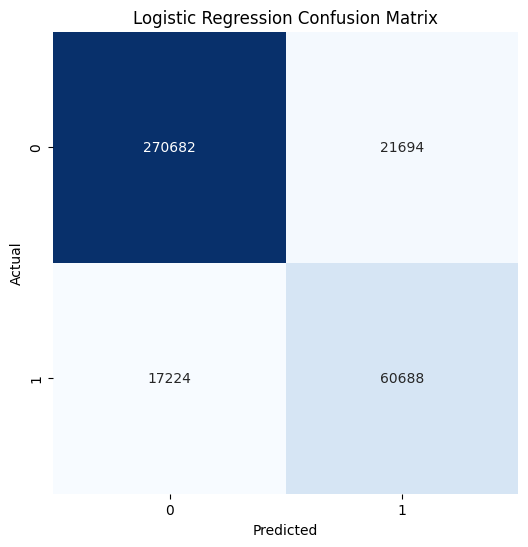

In [22]:
#Logistic Regression
log_reg_model = LogisticRegression(n_jobs=-1)
evaluate_model(log_reg_model, X_train_resampled, y_train_resampled, X_test, y_test, "Logistic Regression")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    292376
           1       0.78      0.76      0.77     77912

    accuracy                           0.90    370288
   macro avg       0.86      0.85      0.86    370288
weighted avg       0.90      0.90      0.90    370288

Average Precision Score (Random Forest): 0.6446


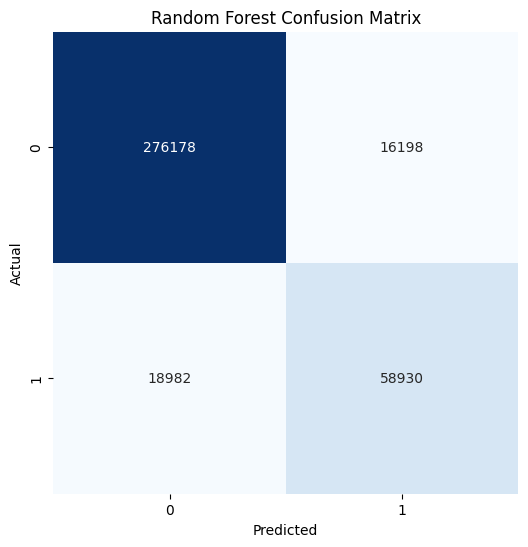

In [27]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100,max_depth=10, min_samples_split= 5,min_samples_leaf=2,criterion='gini', n_jobs=-1)
evaluate_model(rf_model, X_train_resampled, y_train_resampled, X_test, y_test, "Random Forest")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94    292376
           1       0.83      0.73      0.78     77912

    accuracy                           0.91    370288
   macro avg       0.88      0.85      0.86    370288
weighted avg       0.91      0.91      0.91    370288

Average Precision Score (XGBoost): 0.6622


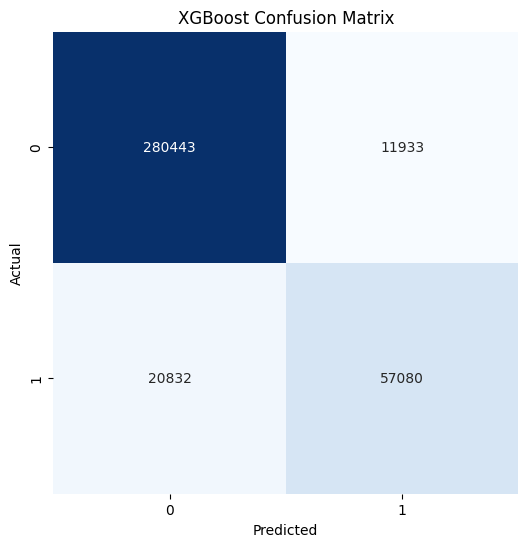

In [26]:
from xgboost import XGBClassifier
# XGBoost
xgb_model = XGBClassifier(n_estimators=50,learning_rate= 0.1,max_depth=10,min_child_weight=3,colsample_bytree=1.0,subsample=1.0,n_jobs=-1)
evaluate_model(xgb_model, X_train_resampled, y_train_resampled, X_test, y_test, "XGBoost")

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92    292376
           1       0.68      0.71      0.70     77912

    accuracy                           0.87    370288
   macro avg       0.80      0.81      0.81    370288
weighted avg       0.87      0.87      0.87    370288

Average Precision Score (Decision Tree): 0.5456


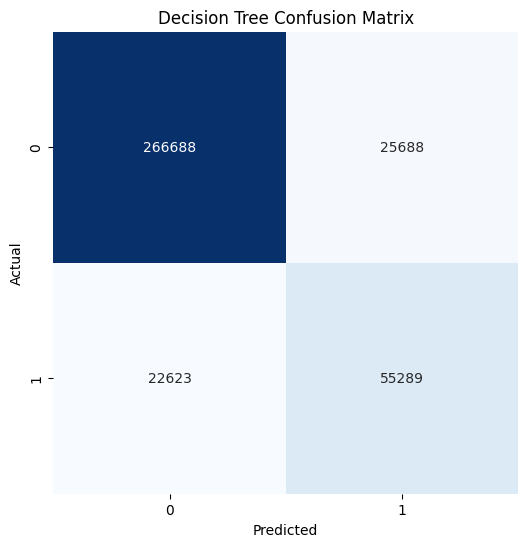

In [19]:
# Decision Tree
dt_model = DecisionTreeClassifier()
evaluate_model(dt_model, X_train_resampled, y_train_resampled, X_test, y_test, "Decision Tree")

**Average Precision Score** is a metric commonly used for evaluating the performance of a classification model, particularly in scenarios where the dataset is imbalanced. It is a measure of the precision-recall trade-off.

Hyper parameter turning can be done by finding best params using grid or random search cv to improve the metric.

# **AUC ROC analysis**

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

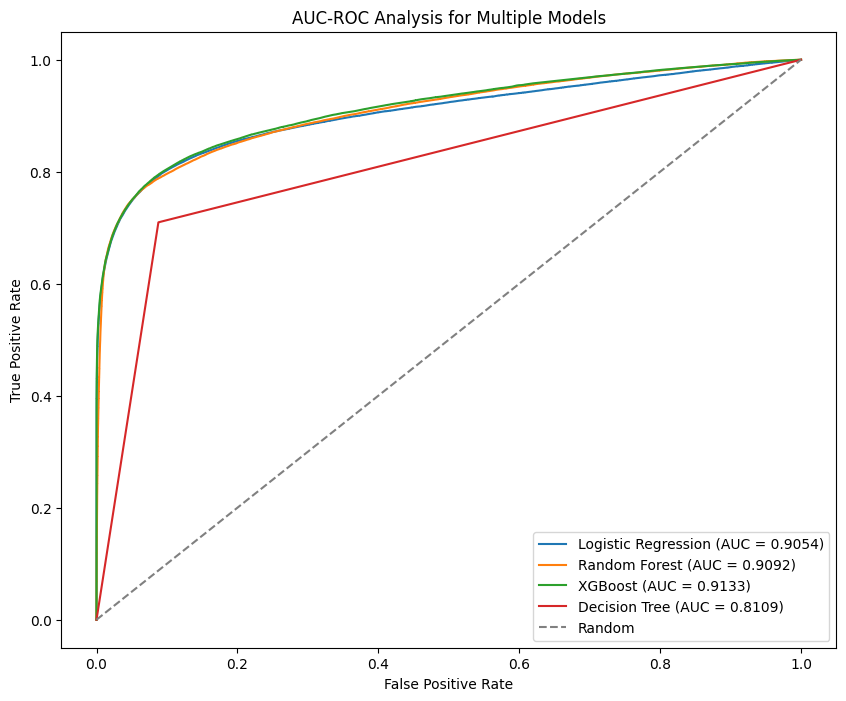

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

def auc_roc_analysis(model, X_test, y_test, model_name):
    # Predict probabilities on the test set
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)

    # Plot ROC curve with AUC score in legend
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})")

# Plot AUC-ROC curves for all models in one plot with legends
plt.figure(figsize=(10, 8))

# Logistic Regression
auc_roc_analysis(log_reg_model, X_test, y_test, "Logistic Regression")

# Random Forest
auc_roc_analysis(rf_model, X_test, y_test, "Random Forest")

# XGBoost
auc_roc_analysis(xgb_model, X_test, y_test, "XGBoost")

# Decision Tree
auc_roc_analysis(dt_model, X_test, y_test, "Decision Tree")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Analysis for Multiple Models')
plt.legend(loc="lower right")
plt.show()